In [56]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load stock data from Yahoo Finance for BAC
data = yf.download('BAC', start='2024-01-01', end='2024-04-16')  # Adjust end date to the most recent complete year




[*********************100%%**********************]  1 of 1 completed


In [57]:
# Calculate SMA and EMA
data['SMA_30'] = data['Adj Close'].rolling(window=30).mean()
data['EMA_12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()

# Calculate RSI
delta = data['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values created by moving averages and RSI calculation
data.dropna(inplace=True)


In [58]:
# Predict future prices; shift up by 1 day
data['Future Price'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)  # Remove any rows with NaN values


In [59]:
# Define features and target
X = data[['Adj Close', 'SMA_30', 'EMA_12', 'RSI']]
y = data['Future Price']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [61]:
# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 0.4980755792202004


In [62]:
## Another MODEL 

In [63]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to train and evaluate a model
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# Prepare the data (assuming 'X_train', 'X_test', 'y_train', 'y_test' are already defined)


In [64]:
# Models
models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting Machine": GradientBoostingRegressor(n_estimators=100),
    "Support Vector Regression": SVR(kernel='rbf'),
    "Neural Network Regressor": MLPRegressor(hidden_layer_sizes=(50, ), max_iter=500)
}

# Results dictionary
results = {}

# Evaluate each model
for name, model in models.items():
    rmse = train_evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = rmse
    print(f"{name} RMSE: {rmse}")


Random Forest Regressor RMSE: 0.4473855422345359
Gradient Boosting Machine RMSE: 0.4057929094054573
Support Vector Regression RMSE: 1.2049024030157858
Neural Network Regressor RMSE: 0.5852299388875798


In [65]:
from sklearn.ensemble import GradientBoostingRegressor

# Assuming these were the parameters that led to the best RMSE
best_params = {
    'n_estimators': 100,  # Example value
    'learning_rate': 0.1,  # Example value
    'max_depth': 3,  # Example value
    'min_samples_split': 2,  # Example value
    'min_samples_leaf': 1  # Example value
}

# Initialize the model with these parameters
model = GradientBoostingRegressor(**best_params)
model.fit(X_train, y_train)

# Predict and calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")


RMSE: 0.40221033098289316


In [66]:
from sklearn.ensemble import GradientBoostingRegressor

# Assuming these were the parameters that led to the best RMSE
best_params = {
    #'n_estimators': 100,  # Example value 100
    #'learning_rate': 0.1,  # Example value 0.1
    #'max_depth': 3,  # Example value 3
    #'min_samples_split': 2,  # Example value 2
    #'min_samples_leaf': 1,  # Example value 1
    
}

# Initialize the model with these parameters
model = GradientBoostingRegressor(**best_params)
model.fit(X_train, y_train)

# Predict and calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")


RMSE: 0.4083272199041314


In [67]:
model = GradientBoostingRegressor(**best_params, random_state=42)


In [68]:
import pickle
import json

# Model saving
with open('successful_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Configuration saving
config = {
    'parameters': {
        'n_estimators': 100,
        'max_depth': 3,
        # add all relevant parameters
    },
    'preprocessing': {
        'scaled': True,
        'features_used': ['SMA_30', 'EMA_12', 'RSI']
    }
}
with open('model_config.json', 'w') as f:
    json.dump(config, f)


In [69]:
import json

# Store model parameters and RMSE in a JSON file for later retrieval
log_data = {
    'params': best_params,
    'rmse': rmse
}

with open('model_log.json', 'w') as f:
    json.dump(log_data, f)


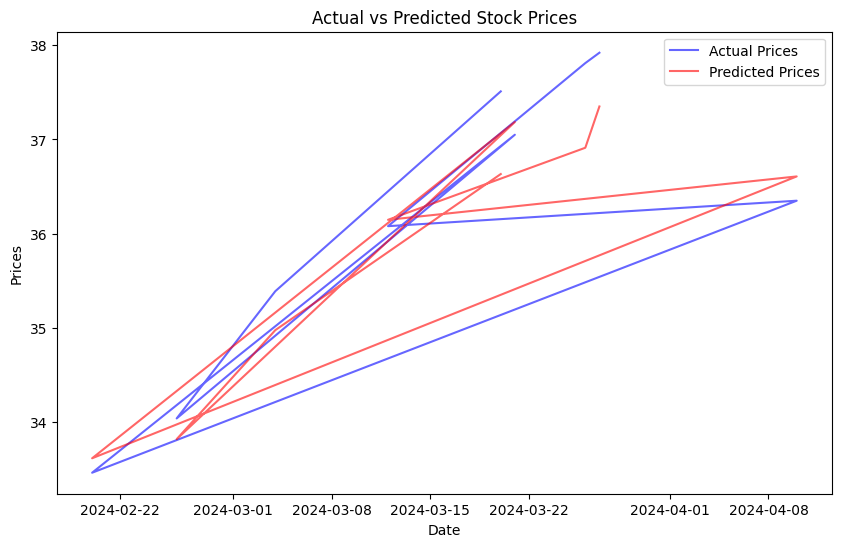

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='red', alpha=0.6)
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()



In [74]:
import pickle
# Save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [78]:
from flask import Flask, request, jsonify
import pickle

# Load the pre-trained model (make sure to provide the correct path to the model file)
model = pickle.load(open('finalized_model.sav', 'rb'))

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Receive data from the client
    data = request.get_json(force=True)
    # Assume data is a dictionary with a key 'features' that contains the input features
    prediction = model.predict([data['features']])
    # Send prediction back to client
    return jsonify(prediction.tolist())

if __name__ == '__main__':
    # Run the Flask application on the default port 5000
    app.run(debug=True)



 * Serving Flask app '__main__'
 * Debug mode: on


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 1076, in launch_instance
    app.initialize(argv)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^

SystemExit: 1